In [74]:
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression
from glob import glob
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cross_decomposition import PLSRegression
from collections import defaultdict 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.linalg import cholesky

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
pheno_cols = ["ADP_PSEL","ADP_FIB","ADP",
               "CRP_PSEL","CRP_FIB","CRP",
               "TRAP_PSEL","TRAP_FIB","TRAP",
               "PAR1_PSEL","PAR1_FIB","PAR1",
               "PAR4_PSEL","PAR4_FIB","PAR4"]

# Load tables

In [76]:
features = pd.read_hdf("%s/processed/features.hdf" % data_dir)
features.sample(3)

,mean_0,mean_1,median_0,median_1,upper_0,upper_1,lower_0,lower_1,std_0,std_1,iqr_0,iqr_1,ratio_upper,ratio_lower,ratio_std
ID,,,,,,,,,,,,,,,
INT_116_2703300,13.576544,-1.077989,10.534885,-1.031977,60.948962,9.993894,-30.254893,-12.142980,36.635179,8.488667,47.909567,11.613466,-0.750483,-0.566149,-0.635241
INT_116_5008800,-10.708686,-3.193342,-11.184856,-2.085116,32.054884,10.913730,-53.949552,-16.822484,34.989534,10.942399,51.867988,14.316819,-0.428233,-0.384425,-0.472131
INT_116_2272100,2.144046,0.057256,-0.367919,0.057191,44.484927,10.821635,-38.304298,-10.776620,32.905161,8.384955,43.479059,11.356769,-0.625824,-0.548279,-0.600452


In [77]:
phenotypes = pd.read_csv("%s/processed/phenotypes.csv" % data_dir,index_col=0).set_index("SAMPLE_ID")
phenotypes = phenotypes[pheno_cols]
phenotypes.sample(3)

,ADP_PSEL,ADP_FIB,ADP,CRP_PSEL,CRP_FIB,CRP,TRAP_PSEL,TRAP_FIB,TRAP,PAR1_PSEL,PAR1_FIB,PAR1,PAR4_PSEL,PAR4_FIB,PAR4
SAMPLE_ID,,,,,,,,,,,,,,,
C0WY3X,0.045418,0.139814,0.092616,-0.458038,-0.539151,-0.498594,0.389466,-0.527180,-0.068857,0.630567,0.017399,0.323983,0.189002,-0.056650,0.066176
C19FXW,-1.158499,-0.625189,-0.891844,0.310888,-0.133630,0.088629,-1.596494,-1.993062,-1.794778,-2.210256,-2.329825,-2.270041,0.027213,-0.138030,-0.055409
C19M6L,0.591514,1.687172,1.139343,-0.039008,1.293526,0.627259,-1.459990,0.749993,-0.354999,-1.497086,0.621604,-0.437741,0.126752,1.385625,0.756188


In [78]:
sysmex_features = pd.read_csv("%s/processed/sysmex_features.csv" % data_dir,index_col=0)
sysmex_features.sample(3)

,PLT,MPV,PDW,PCT,IPF
INT_116_1963900,229.891013,11.929374,14.283966,0.278759,3.680120
INT_116_2193800,185.941263,10.543503,11.977990,0.187900,2.983813
INT_116_5436700,204.547044,10.957972,13.270263,0.219065,3.670246


In [79]:
sys_agesex, int_agesex = get_ages_sex()
agesex = pd.concat((sys_agesex,int_agesex),axis=0)

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [80]:
agesex.sample(3)

,SEX,AGE
INT_116_328000,2,57.4
INT_116_7698100,2,19.0
INT_116_5390500,2,51.3


# Merge them

In [81]:
print(agesex.shape[0])
print(sysmex_features.shape[0])
covars = pd.merge(agesex, sysmex_features,left_index=True,right_index=True,how="inner")
print(covars.shape[0])
covars.sample(3)

34924
33362
33362


,SEX,AGE,PLT,MPV,PDW,PCT,IPF
INT_116_2881400,1,52.9,281.730733,11.196182,13.765836,0.315932,3.118841
INT_116_4322100,1,42.3,257.795602,13.208924,18.767735,0.343207,7.840590
INT_116_5262200,1,43.6,292.976209,10.021744,11.203691,0.284699,1.673110


In [82]:
print(features.shape[0])
X_all = pd.merge(covars, features,left_index=True,right_index=True)
print(X_all.shape[0])

33366
33358


In [83]:
X_all.sample(3)

,SEX,AGE,PLT,MPV,PDW,PCT,IPF,mean_0,mean_1,median_0,...,upper_1,lower_0,lower_1,std_0,std_1,iqr_0,iqr_1,ratio_upper,ratio_lower,ratio_std
INT_116_930200,1,64.6,260.710754,12.115706,16.590680,0.322615,3.535856,-3.899862,1.183904,-8.181014,...,14.059922,-45.223554,-10.765591,36.121409,9.852089,46.720903,12.520696,-0.512709,-0.509280,-0.560521
INT_116_701700,2,44.0,314.547044,11.557972,14.770263,0.359065,1.970246,-4.351832,-0.981022,-7.394957,...,9.591877,-42.737962,-11.866505,31.995719,8.570485,41.339458,11.255357,-0.553721,-0.510825,-0.571952
INT_116_2137100,1,25.3,198.891013,11.929374,15.283966,0.238759,6.680120,10.226938,1.882748,4.887980,...,14.317347,-37.264059,-10.203262,40.713308,9.611607,52.184117,12.833933,-0.699083,-0.551709,-0.624009


In [89]:
covar_cols = covars.columns
#features_to_use = ["upper_0","mean_1","ratio_lower"]
features_cols = ["upper_0","mean_0","mean_1","lower_1","iqr_0","ratio_lower"]
#features_cols = features.columns
#features_cols = ["lower_0","upper_0","std_0","iqr_0","ratio_upper","ratio_lower","ratio_std","PC_0","PC_1","PC_2","PC_4"]

# Adjust features by phenotypes

In [90]:
covar_cols = ["SEX","AGE","PLT","MPV","PDW","IPF","PCT"]

In [91]:
def correlate(X, cols1,cols2):
    C = (1./X.shape[0])*((X[cols1] - X[cols1].mean(axis=0))/X[cols1].std(axis=0)).T @ ((X[cols2] - X[cols2].mean(axis=0))/X[cols2].std(axis=0))
    return C

In [92]:
X_train = pd.merge(X_all,phenotypes,left_index=True,right_index=True,how="inner")
X_train_adj = X_train.copy()

X_int = X_all.loc[X_all.index.str.contains("INT_116")]
X_int_adj = X_int.copy()

lm_train = PLSRegression(n_components=4).fit(X_train[covar_cols],X_train[features_cols])
lm_int = PLSRegression(n_components=4).fit(X_int[covar_cols],X_int[features_cols])

# WHAT IF : we use lm_int everwhere -> marche pas

X_train_adj[features_cols] -= lm_train.predict(X_train[covar_cols])
# Rajouté à partir du 16 juin, ainsi que sur la cohorte INTERVAL
train_std = X_train_adj[features_cols].std(axis=0)
X_train_adj[features_cols] /= train_std


X_int_adj[features_cols] -= lm_int.predict(X_int[covar_cols])
# Rajouté à partir du 16 juin, ainsi que sur la cohorte INTERVAL
int_std = X_int_adj[features_cols].std(axis=0)
X_int_adj[features_cols] /= int_std

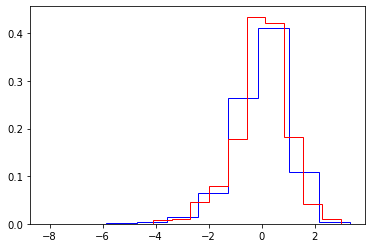

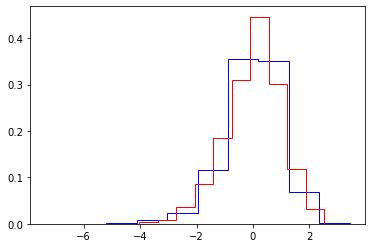

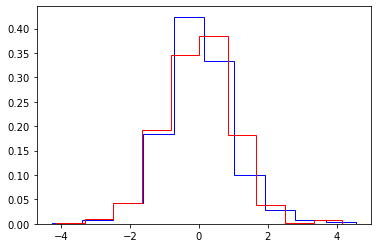

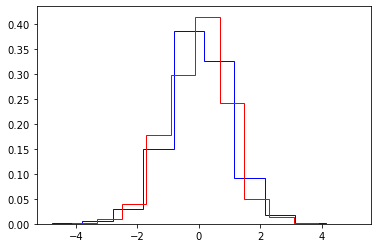

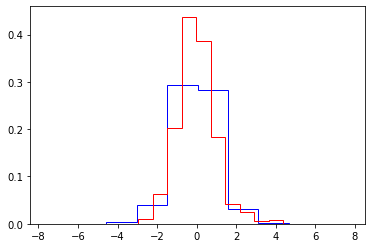

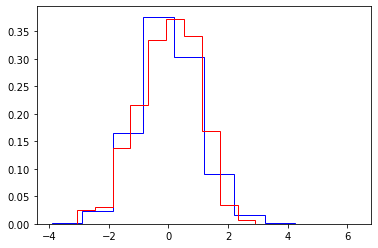

In [93]:
for f in features_cols:
    plt.figure()
    plt.hist(X_int_adj[f],color="blue",histtype="step",density=True)
    plt.hist(X_train_adj[f],color="red",histtype="step",density=True)

In [94]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [95]:
int_values = X_int_adj[features_cols]

20 BKPS
32 BKPS


<Figure size 1008x504 with 0 Axes>

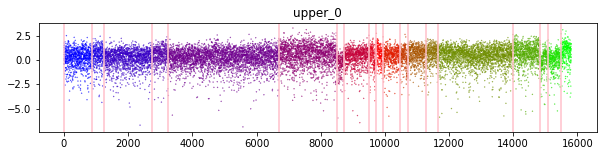

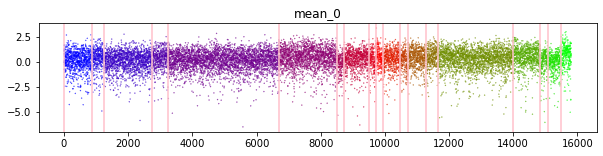

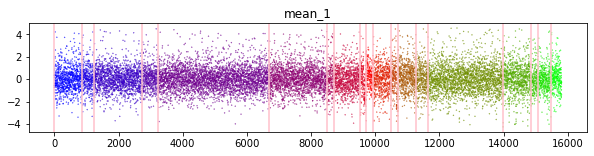

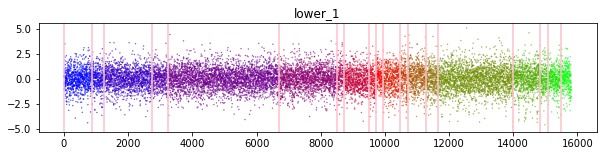

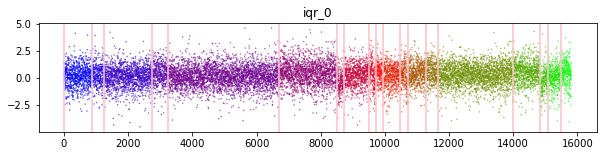

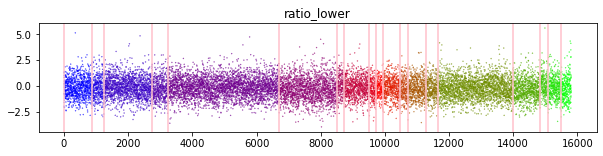

<Figure size 1008x504 with 0 Axes>

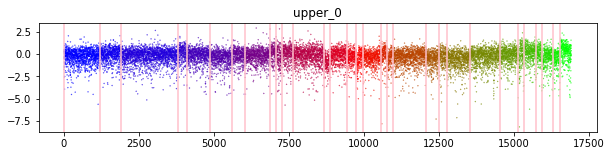

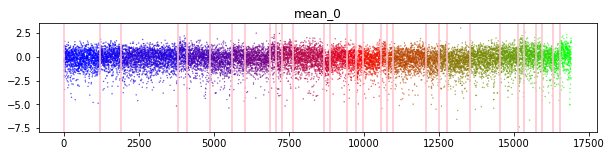

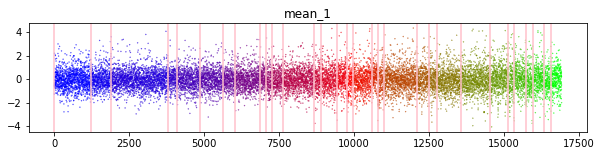

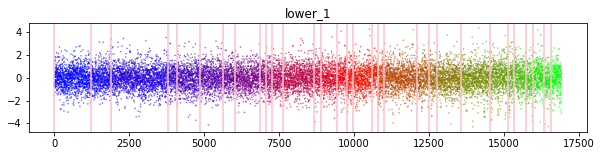

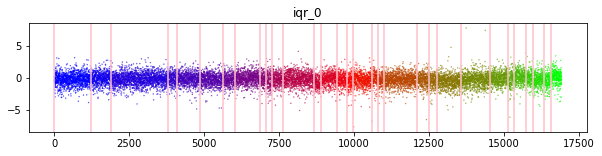

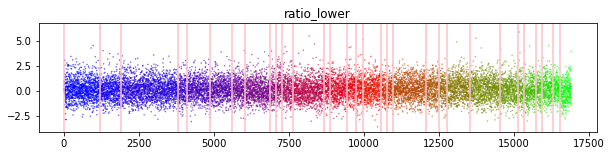

In [96]:
cohort_offset = 0
machines = int_phen["Instrument"].unique().tolist()
int_infos = []
for instrument in machines:
    int_info = pd.merge(int_values, int_phen.loc[int_phen.Instrument == instrument,
                                                      ["SampleNo","DateTime"]],
                        left_index=True,right_on="SampleNo",how="inner")
    
    int_info.sort_values("DateTime",inplace=True)
    X = int_info[features_cols].values
    
    algo_c = rp.KernelCPD(kernel="rbf", min_size=200).fit(
        X
    )
    
    bkps = algo_c.predict(pen=2.3)
    bkps = [0] + bkps
    print("%d BKPS" % len(bkps))

    int_info["cohort"] = cohort_offset
    int_info["rank"] = np.arange(int_info.shape[0])
    for b in bkps[1:]:
        int_info.loc[int_info["rank"] >= b,"cohort"] += 1

    plt.figure(figsize=(14,7))
    for i in range(X.shape[1]):
        plt.figure(figsize=(10,2))
        plt.title(features_cols[i])
        plt.scatter(int_info["rank"],X[:,i],s=.1,c=int_info.cohort,cmap="brg")
        for b in bkps[:-1]:
            plt.axvline(int_info["rank"].iloc[b],c="pink")
    int_infos.append(int_info)
    cohort_offset = int_info.cohort.max() + 1
int_info = pd.concat(int_infos,axis=0)

In [97]:
for c in int_info.cohort.unique():
    cond = int_info.cohort == c
    int_info.loc[cond,features_cols] -= int_info.loc[cond,features_cols].mean()
    # Added
    # int_info.loc[cond,features_cols] /= int_info.loc[cond,features_cols].std()

In [98]:
int_info.set_index("SampleNo",inplace=True)

In [99]:
for f in features_cols:
    if f in X_int_adj.columns:
        del X_int_adj[f]
X_int_adj = pd.merge(X_int_adj,int_info[features_cols],left_index=True,right_index=True)

In [100]:
int_std *= X_int_adj[features_cols].std(axis=0)

In [101]:
X_int_adj  [features_cols] = np.clip(X_int_adj  [features_cols],-4,4)
X_train_adj[features_cols] = np.clip(X_train_adj[features_cols],-4,4)

In [102]:
C_train = correlate(X_train, covar_cols,features_cols)
C_train_adj = correlate(X_train_adj, covar_cols,features_cols)
Q_train = correlate(X_train, features_cols,features_cols)
Q_train_adj = correlate(X_train_adj, features_cols,features_cols)

C_int = correlate(X_int, covar_cols,features_cols)
C_int_adj = correlate(X_int_adj, covar_cols,features_cols)
Q_int = correlate(X_int, features_cols,features_cols)
Q_int_adj = correlate(X_int_adj, features_cols,features_cols)

In [103]:
plot_args = {"vmin":-1,"vmax":1,"cmap":"bwr"}

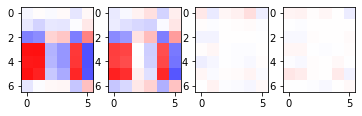

In [104]:
fig = plt.figure()
ax = fig.add_subplot(1,4,1)
ax.imshow(C_train,**plot_args)
ax = fig.add_subplot(1,4,2)
ax.imshow(C_int,**plot_args)
ax = fig.add_subplot(1,4,3)
ax.imshow(C_train_adj,**plot_args)
ax = fig.add_subplot(1,4,4)
ax.imshow(C_int_adj,**plot_args)

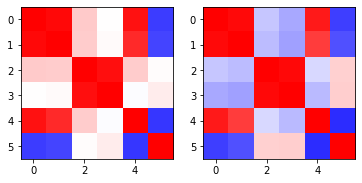

In [105]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(Q_int,**plot_args)
ax = fig.add_subplot(122)
ax.imshow(Q_train,**plot_args)

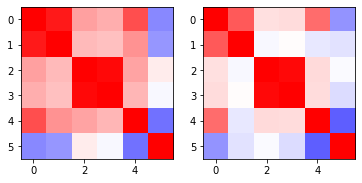

In [106]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(Q_int_adj,**plot_args)
ax = fig.add_subplot(122)
ax.imshow(Q_train_adj,**plot_args)

In [107]:
chol_adj = False

if chol_adj:

    L_int = cholesky(Q_int_adj)
    L_train = cholesky(Q_train_adj)
    X_int_decorr = X_int_adj.copy()
    X_int_decorr[features_cols] = X_int_adj[features_cols] @ np.linalg.inv(L_int)
    print(correlate(X_int_decorr,features_cols,features_cols))
    X_int_recorr = X_int_decorr.copy()
    X_int_recorr[features_cols] = X_int_recorr[features_cols] @ L_train
    print(correlate(X_int_recorr,features_cols,features_cols))
    print(Q_train_adj)
    for f in features_cols:
        plt.scatter(X_int_adj[f],X_int_recorr[f],label=f)
    plt.legend()
    X_int_adj = X_int_recorr

In [108]:
Q_int_adj = correlate(X_int_adj, features_cols,features_cols)

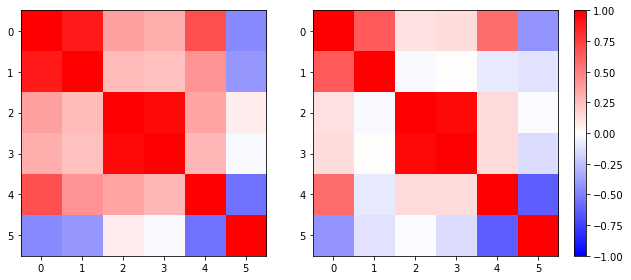

In [109]:
fig = plt.figure(figsize=(9.3,4))
ax = fig.add_subplot(121)
ax.imshow(Q_int_adj,**plot_args)
ax = fig.add_subplot(122)
cm  = ax.imshow(Q_train_adj,**plot_args)
plt.colorbar(cm)
plt.tight_layout()

In [110]:
pca_train = PCA().fit(X_train_adj[features_cols])
pca_int = PCA().fit(X_int_adj[features_cols])

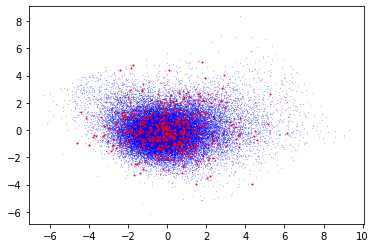

In [111]:
X_t_train = pca_train.transform(X_train_adj[features_cols])
X_t_int   = pca_train.transform(X_int_adj  [features_cols])

plt.scatter(X_t_int  [:,0],X_t_int  [:,1],s=.01,c="blue")
plt.scatter(X_t_train[:,0],X_t_train[:,1],s=1,c="red")

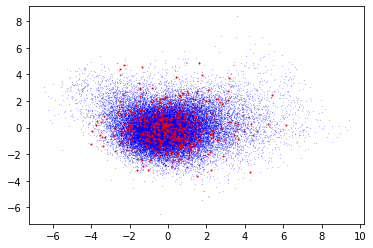

In [112]:
X_t_train = pca_int.transform(X_train_adj[features_cols])
X_t_int   = pca_int.transform(X_int_adj  [features_cols])

plt.scatter(X_t_int  [:,0],X_t_int  [:,1],s=.01,c="blue")
plt.scatter(X_t_train[:,0],X_t_train[:,1],s=1,c="red")

In [113]:
print(train_std)

upper_0        3.029808
mean_0         2.310411
mean_1         1.246036
lower_1        1.178070
iqr_0          2.145745
ratio_lower    0.024547
dtype: float64


In [114]:
print(int_std)

upper_0        5.381514
mean_0         4.366723
mean_1         1.638375
lower_1        1.374604
iqr_0          2.393413
ratio_lower    0.026043
dtype: float64


In [115]:
re_scale = True
# -> Il vaut mieux mettre True
if re_scale:
    X_int_adj[features_cols] *= int_std
    X_train_adj[features_cols] *= train_std

In [116]:
pd.concat([X_int_adj[features_cols].std(axis=0),X_train_adj[features_cols].std(axis=0)],axis=1)

,0,1
upper_0,4.911928,3.027493
mean_0,4.118304,2.309808
mean_1,1.628058,1.243226
lower_1,1.367336,1.176991
iqr_0,2.257373,2.139308
ratio_lower,0.025565,0.024547


# Estimate performance

In [117]:
N_PLS_COMPS = 1

In [118]:
rho_cov = defaultdict(lambda: [])
rho_all = defaultdict(lambda: [])
y_pred_test = {}
y_test = {}
r2_cov = defaultdict(lambda: [])
r2_all = defaultdict(lambda: [])
r2_res = defaultdict(lambda: [])
for c in pheno_cols:
    skf = RepeatedStratifiedKFold(n_splits=4,n_repeats=30)
    y = X_train_adj[c]
    cond = ~y.isnull()
    X = X_train_adj.loc[cond,features_cols]
    C = X_train_adj.loc[cond,covar_cols]
    y = y.loc[cond]
    
    y_split = pd.cut(y,5,labels=False)
    
    for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(y_split)), y_split)):
        #print(len(train_index),len(test_index))
        pls = PLSRegression(n_components=1)
        pls.fit(C.iloc[train_index],y.iloc[train_index])
        y_cov = np.reshape(pls.predict(C),(-1,1))
        
        residuals = y-y_cov[:,0]
        pls_res = PLSRegression(n_components=N_PLS_COMPS)
        #pls_res = LinearRegression()
        pls_res.fit(X.iloc[train_index],residuals.iloc[train_index])
        y_res = np.reshape(pls_res.predict(X),(-1,1))
        y_pred = y_cov + y_res
        
        pearson_all = pearsonr(y.iloc[test_index],y_pred[test_index,0])[0]
        pearson_cov = pearsonr(y.iloc[test_index],y_cov[test_index,0])[0]
        
        rho_cov[c].append(pearson_cov)
        rho_all[c].append(pearson_all)
        r2_all[c].append(r2_score(y.iloc[test_index],y_pred[test_index,0]))
        r2_cov[c].append(r2_score(y.iloc[test_index],y_cov[test_index,0]))
        r2_res[c].append(r2_score(residuals.iloc[test_index],y_res[test_index,0]))
        
        if i == 0:
            
            y_pred_test[c] = y_pred[test_index,0]
            y_test[c] = y.iloc[test_index]
        

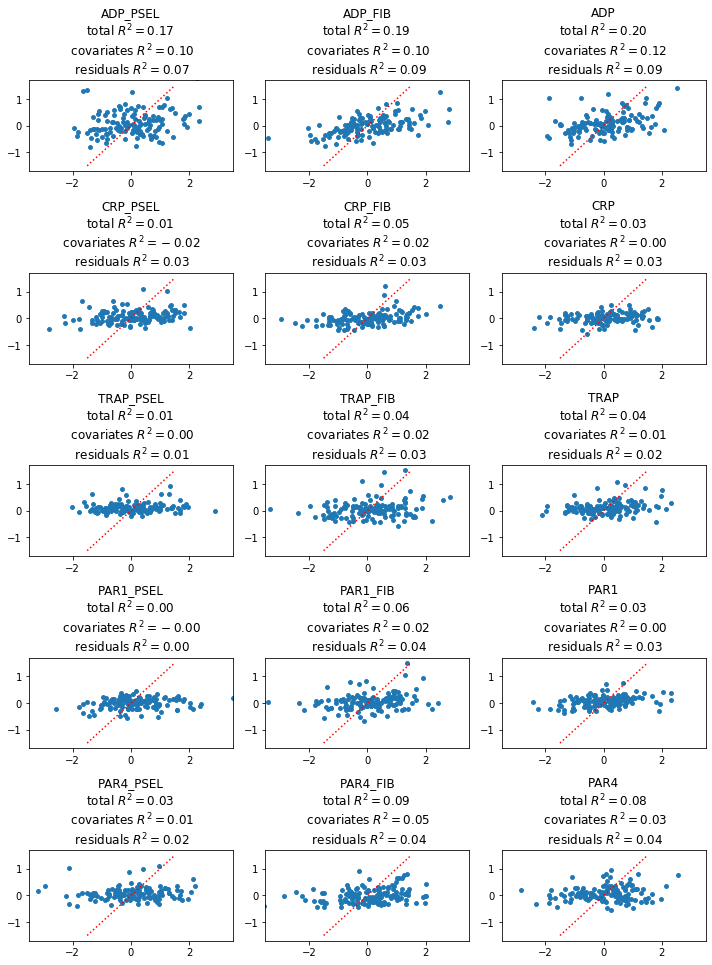

In [119]:
from sklearn.metrics import r2_score
fig = plt.figure(figsize=(10,40))
for i, c in enumerate(pheno_cols):
    ax = fig.add_subplot(len(pheno_cols),3,i+1)
    ax.scatter(y_test[c],y_pred_test[c],s=15)
    ax.set_ylim((-1.7,1.7))
    ax.set_xlim((-3.5,3.5))
    ax.plot([-1.5,1.5],[-1.5,1.5],c="red",ls=":")
    #R2 = r2_score(y_test[c],y_pred_test[c])
    R2 = np.median(r2_all[c])
    R2_res = np.median(r2_res[c])
    R2_cov = np.median(r2_cov[c])
    ax.set_title("%s\ntotal $R^2=%.2f$ \n covariates $R^2 = %.2f $ \n residuals $ R^2=%.2f $" % (c,R2,R2_cov,R2_res))
plt.tight_layout()
#plt.savefig("%s/predictions_test.pdf" % export_folder)

# Fit on whole dataset

In [120]:
pls = {}
pls_res = {}

predictions = pd.DataFrame(index=X_train_adj.index)

for c in pheno_cols:
    y = X_train_adj[c]
    cond = ~y.isnull()
    X = X_train_adj.loc[cond,features_cols]
    C = X_train_adj.loc[cond,covar_cols]
    y = y.loc[cond]
    
    pls[c] = PLSRegression(n_components=1)
    pls[c].fit(C,y)
    y_cov = np.reshape(pls[c].predict(C),(-1,1))

    residuals = y-y_cov[:,0]
    if X.shape[1] >= 4:
        pls_res[c] = PLSRegression(n_components=N_PLS_COMPS)
    else:
        pls_res[c] = LinearRegression()
    pls_res[c].fit(X,residuals)
    y_pred = y_cov + np.reshape(pls_res[c].predict(X),(-1,1))
    
    predictions[c] = np.nan
    predictions.loc[cond,c] = y_pred[:,0]

# Predict on Interval

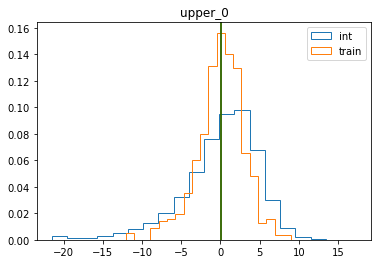

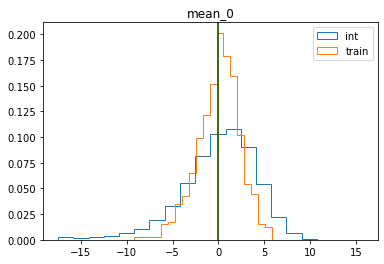

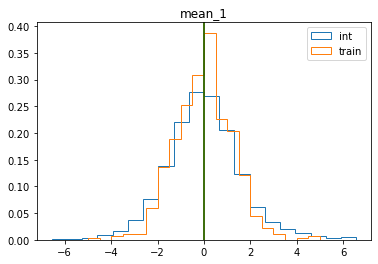

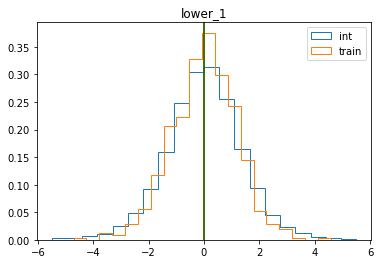

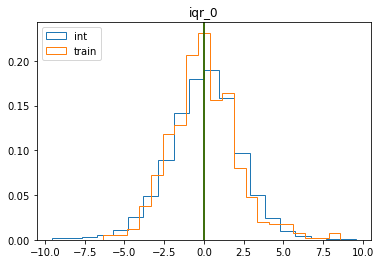

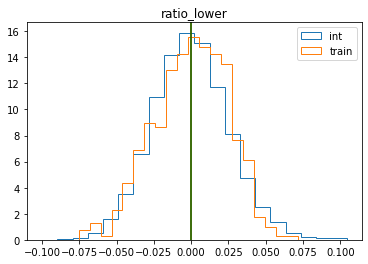

In [121]:
for f in features_cols:
    plt.figure()
    plt.hist(X_int_adj[f],density=True,histtype="step",bins=20,label="int")
    plt.axvline(np.mean(X_int_adj[f]),c="red")
    plt.hist(X_train_adj[f],density=True,histtype="step",bins=20,label="train")
    plt.axvline(np.mean(X_train_adj[f]),c="green")
    plt.title(f)
    plt.legend()

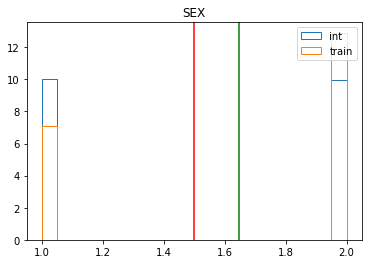

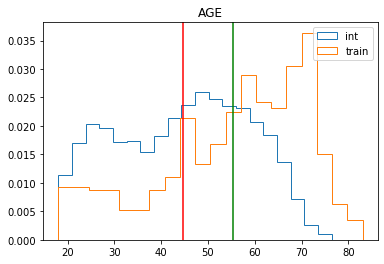

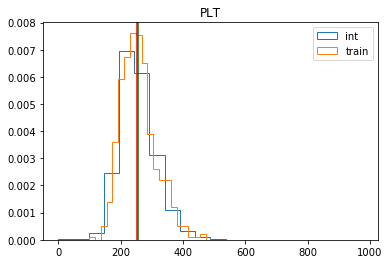

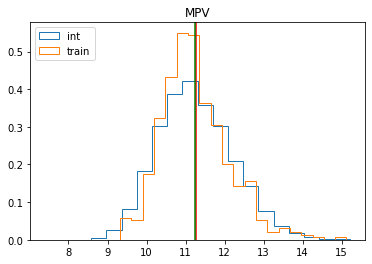

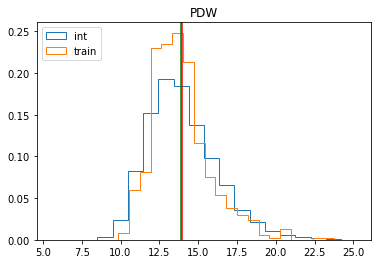

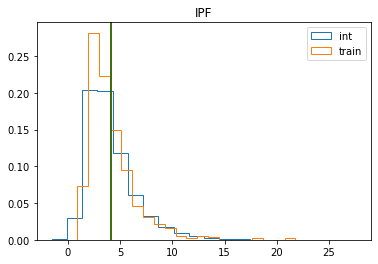

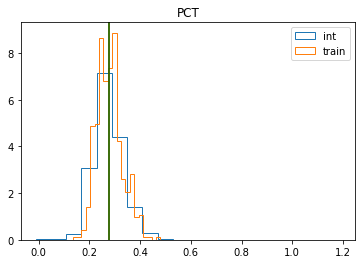

In [122]:
for f in covar_cols:
    plt.figure()
    plt.hist(X_int_adj[f],density=True,histtype="step",bins=20,label="int")
    plt.axvline(np.mean(X_int[f]),c="red")
    plt.hist(X_train_adj[f],density=True,histtype="step",bins=20,label="train")
    plt.axvline(np.mean(X_train[f]),c="green")
    plt.title(f)
    plt.legend()

In [123]:
predictions = pd.DataFrame(index=X_int_adj.index)

for c in pheno_cols:
    X = X_int_adj[features_cols]
    C = X_int_adj[covar_cols]
    
    y_cov = np.reshape(pls[c].predict(C),(-1,1))
    y_pred = np.reshape(pls_res[c].predict(X),(-1,1)) #+ y_cov 
    
    predictions[c] = y_pred[:,0]

In [124]:
predictions

,ADP_PSEL,ADP_FIB,ADP,CRP_PSEL,CRP_FIB,CRP,TRAP_PSEL,TRAP_FIB,TRAP,PAR1_PSEL,PAR1_FIB,PAR1,PAR4_PSEL,PAR4_FIB,PAR4
INT_116_6580100,-0.125002,-0.178162,-0.150108,-0.129207,-0.118928,-0.126380,-0.063665,-0.143633,-0.091506,-0.133138,-0.177150,-0.161100,-0.123851,-0.133091,-0.124643
INT_116_6580000,-0.464866,-0.513773,-0.482828,-0.324659,-0.366823,-0.328603,-0.214318,-0.354749,-0.279531,-0.185903,-0.375508,-0.289978,-0.272214,-0.401840,-0.340402
INT_116_4555900,0.298321,0.337426,0.314878,0.180597,0.219953,0.196546,0.126625,0.223649,0.166694,0.104707,0.241729,0.175562,0.191151,0.267408,0.229265
INT_116_4555800,-0.221271,-0.227558,-0.220623,-0.138186,-0.166627,-0.140351,-0.100549,-0.153295,-0.129391,-0.057109,-0.148565,-0.105886,-0.108655,-0.181031,-0.148478
INT_116_4556000,0.177961,0.218874,0.195145,0.182181,0.173638,0.172238,0.091851,0.172280,0.122992,0.147784,0.211286,0.189625,0.139914,0.171608,0.154540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INT_116_6536800,-0.563664,-0.606252,-0.575826,-0.331049,-0.412879,-0.345167,-0.246865,-0.418325,-0.331028,-0.168392,-0.417285,-0.300382,-0.294910,-0.481379,-0.396715
INT_116_1943800,0.183955,0.190026,0.186220,0.107842,0.133100,0.118368,0.078481,0.105799,0.091749,0.029672,0.110407,0.069832,0.102134,0.149980,0.126614
INT_116_4535600,-0.070706,-0.082256,-0.076265,-0.034064,-0.045284,-0.041909,-0.028351,-0.050290,-0.036797,-0.017702,-0.050018,-0.032143,-0.050445,-0.063091,-0.055496
INT_116_6545900,0.090635,0.104401,0.097947,0.066396,0.072240,0.072460,0.039943,0.058706,0.045530,0.033682,0.072423,0.053428,0.067755,0.080442,0.072254


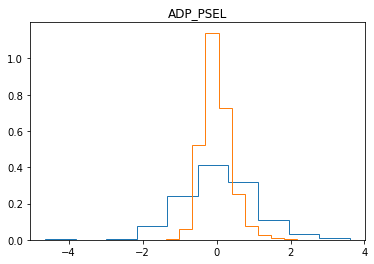

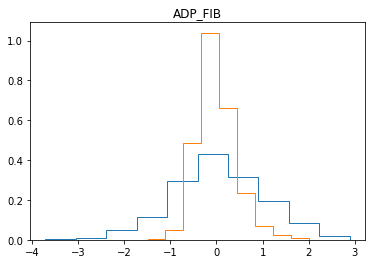

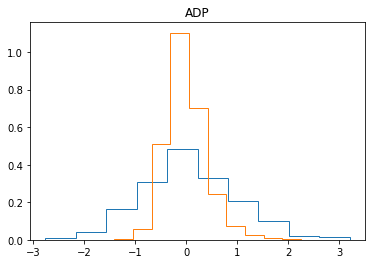

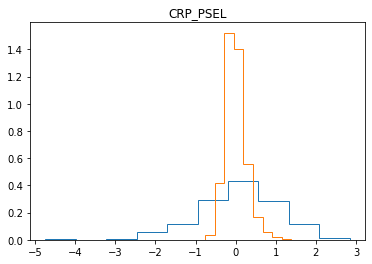

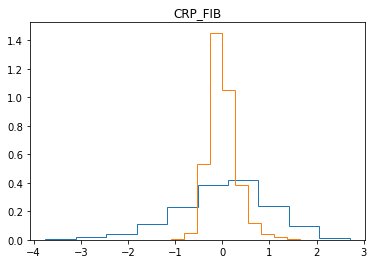

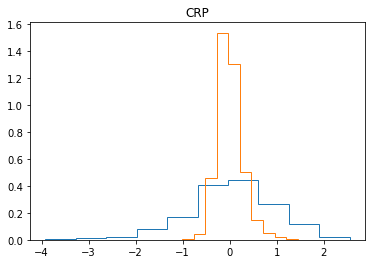

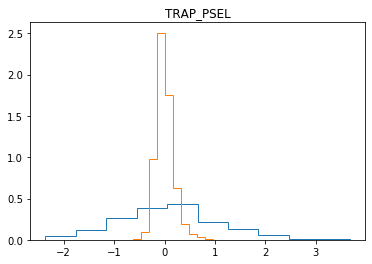

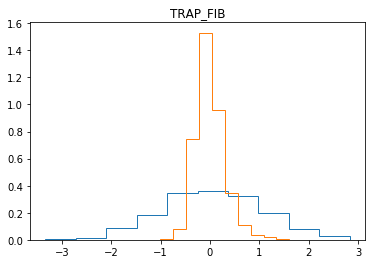

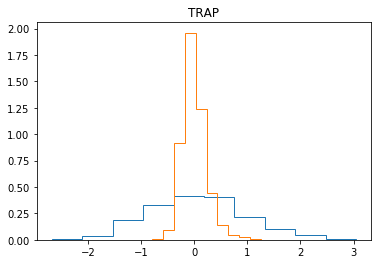

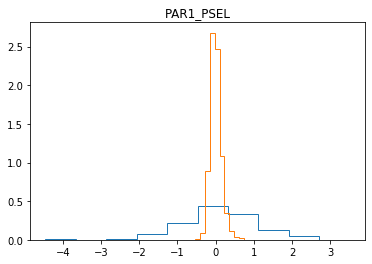

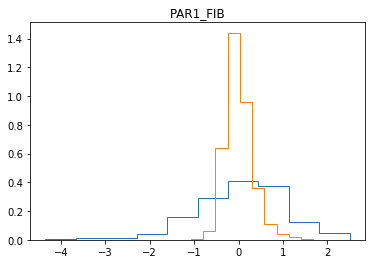

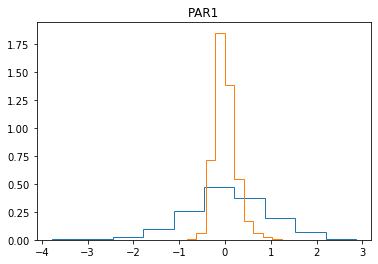

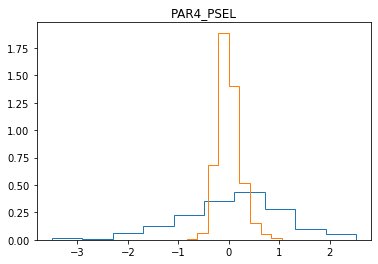

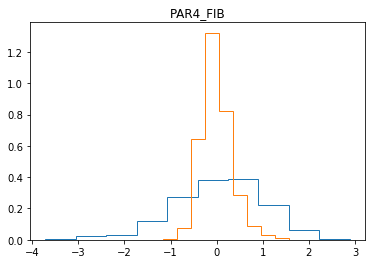

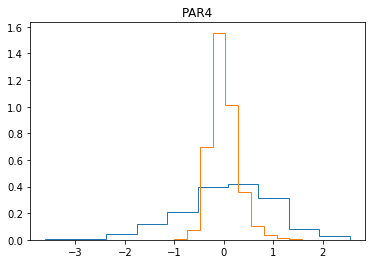

In [125]:
for c in pheno_cols:
    plt.figure()
    plt.hist(phenotypes[c],histtype="step",density=True)
    plt.hist(predictions[c],histtype="step",density=True)
    plt.title(c)

In [126]:
pls_res[c].coef_

array([[-0.06465988],
       [-0.02787032],
       [-0.03117759],
       [-0.04037247],
       [-0.05907987],
       [ 0.0788516 ]])

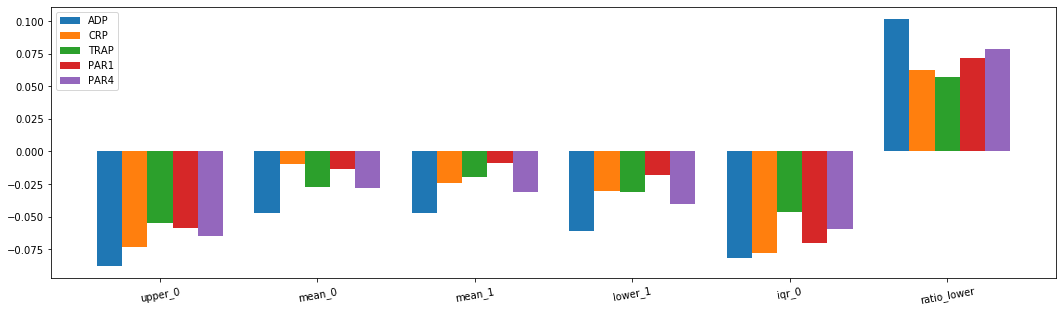

In [127]:
plt.figure(figsize=(18,5))
w = 0.16
for i,c in enumerate([c for c in pheno_cols if "_" not in c]):
    plt.bar(x=np.arange(len(features_cols))+w*(i-2),height=pls_res[c].coef_[:,0],width=w,label=c)
plt.xticks(np.arange(len(features_cols)),features_cols,rotation=10)
plt.legend();

# Export cohorts and predictions

In [128]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [129]:
comp = pd.merge(predictions,int_phen,left_index=True,right_on="SampleNo")
comp = pd.merge(comp, int_info[["cohort"]],left_on="SampleNo",right_index=True)

In [132]:
comp[["SampleNo","cohort"]].to_csv("%s/processed/bkpts_cohorts.csv" % data_dir,index=False)
comp.set_index("SampleNo")[predictions.columns].to_csv("%s/processed/predictions.csv" % data_dir)

# Fix breakpoints and Export

In [914]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [915]:
comp = pd.merge(predictions,int_phen,left_index=True,right_on="SampleNo")

In [916]:
comp["DateTime"] = pd.to_datetime(comp["DateTime"])
comp.sort_values("DateTime",inplace=True)
comp["rank"] = np.arange(comp.shape[0])

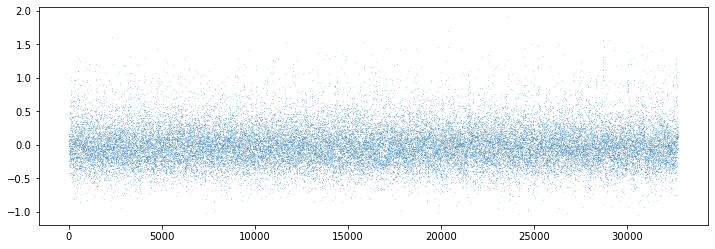

In [917]:
plt.figure(figsize=(12,4))
plt.scatter(comp["rank"],comp.ADP,s=.01)

In [918]:
int_values = predictions

In [919]:
pred_cols = ["ADP","CRP","TRAP","PAR1","PAR4"]

17 BKPS
18 BKPS


<Figure size 1008x504 with 0 Axes>

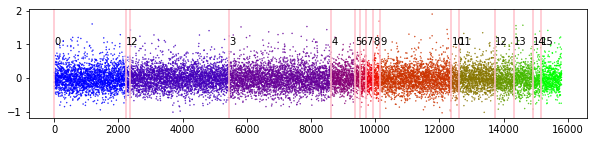

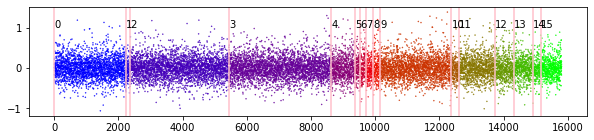

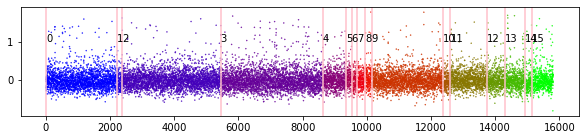

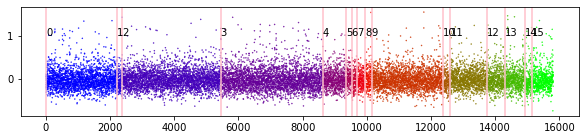

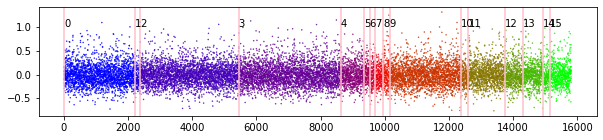

<Figure size 1008x504 with 0 Axes>

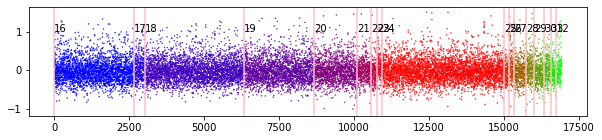

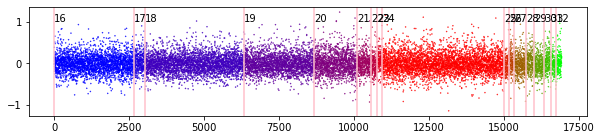

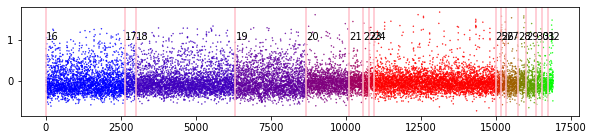

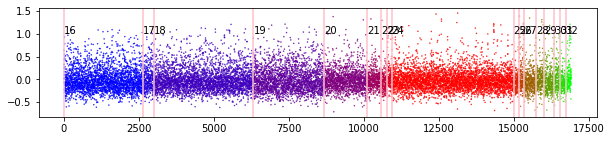

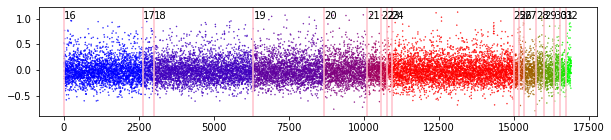

In [920]:
cohort_offset = 0
machines = int_phen["Instrument"].unique().tolist()
int_infos = []
for instrument in machines:
    int_info = pd.merge(int_values, int_phen.loc[int_phen.Instrument == instrument,
                                                      ["SampleNo","DateTime"]],
                        left_index=True,right_on="SampleNo",how="inner")
    
    int_info.sort_values("DateTime",inplace=True)
    X = int_info[pred_cols].values
    
    algo_c = rp.KernelCPD(kernel="rbf", min_size=150).fit(
        X
    )
    
    bkps = algo_c.predict(pen=2.)
    bkps = [0] + bkps
    print("%d BKPS" % len(bkps))

    int_info["cohort"] = cohort_offset
    int_info["rank"] = np.arange(int_info.shape[0])
    for b in bkps[1:]:
        int_info.loc[int_info["rank"] >= b,"cohort"] += 1

    plt.figure(figsize=(14,7))
    for i in range(X.shape[1]):
        plt.figure(figsize=(10,2))
        plt.scatter(int_info["rank"],X[:,i],s=.2,c=int_info.cohort,cmap="brg")
        for j, b in enumerate(bkps[:-1]):
            plt.axvline(int_info["rank"].iloc[b],c="pink")
            plt.text(int_info["rank"].iloc[b], 1, "%d" % int_info.iloc[b].cohort)
    int_infos.append(int_info)
    cohort_offset = int_info.cohort.max() + 1
int_info = pd.concat(int_infos,axis=0)

In [932]:
int_info.loc[(int_info.cohort == 20),"rank"].min()

8668

In [933]:
int_info.loc[int_info.cohort >= 16].shape

(16919, 18)

In [921]:
#for c in int_info.cohort.unique():
#    cond = int_info.cohort == c
#    int_info.loc[cond,pred_cols] -= int_info.loc[cond,pred_cols].mean()
#    int_info.loc[cond,pred_cols] /= int_info.loc[cond,pred_cols].std()

In [922]:
int_info.columns

Index(['ADP_PSEL', 'ADP_FIB', 'ADP', 'CRP_PSEL', 'CRP_FIB', 'CRP', 'TRAP_PSEL',
       'TRAP_FIB', 'TRAP', 'PAR1_PSEL', 'PAR1_FIB', 'PAR1', 'PAR4_PSEL',
       'PAR4_FIB', 'PAR4', 'SampleNo', 'DateTime', 'cohort', 'rank'],
      dtype='object')

In [923]:
int_info = int_info.set_index("SampleNo")

In [924]:
int_info.head()

,ADP_PSEL,ADP_FIB,ADP,CRP_PSEL,CRP_FIB,CRP,TRAP_PSEL,TRAP_FIB,TRAP,PAR1_PSEL,PAR1_FIB,PAR1,PAR4_PSEL,PAR4_FIB,PAR4,DateTime,cohort,rank
SampleNo,,,,,,,,,,,,,,,,,,
INT_116_6580100,-0.132658,-0.106129,-0.117742,0.039648,-0.002846,0.010195,-0.231120,-0.240970,-0.220620,-0.167379,-0.197297,-0.177727,-0.097016,-0.103037,-0.100689,2013-03-01 10:19:44,0,0
INT_116_6580000,-0.243371,-0.249867,-0.245668,-0.158188,-0.171818,-0.165072,-0.200506,-0.253094,-0.216764,-0.167434,-0.236639,-0.204958,-0.168095,-0.200209,-0.182060,2013-03-01 10:21:00,0,1
INT_116_4555900,0.115697,0.212318,0.163520,0.226538,0.214457,0.210335,-0.051957,0.042516,0.001196,0.016034,0.110241,0.075194,0.126462,0.174060,0.147250,2013-03-01 10:23:33,0,2
INT_116_4555800,-0.155703,-0.111284,-0.132753,-0.041457,-0.061299,-0.054582,-0.185841,-0.185672,-0.176520,-0.120049,-0.135002,-0.124981,-0.074288,-0.086094,-0.079744,2013-03-01 10:24:49,0,3
INT_116_4556000,0.124419,0.207900,0.165048,0.266008,0.237062,0.241951,-0.004423,0.070776,0.038820,0.055413,0.141515,0.113489,0.151769,0.185505,0.162966,2013-03-01 10:26:06,0,4


In [925]:
int_info[predictions.columns].to_csv("%s/processed/predictions.csv" % data_dir)

In [926]:
int_info[["cohort"]].to_csv("%s/processed/bkpts_cohorts.csv" % data_dir)

In [927]:
int_info.cohort.value_counts().sort_values()

1      151
23     153
26     166
5      169
31     178
25     179
6      179
32     185
22     200
8      210
30     213
14     229
10     231
7      235
28     266
29     335
17     362
27     403
21     473
12     579
13     611
15     653
4      734
11    1132
20    1435
9     2220
0     2223
19    2350
16    2646
2     3073
3     3179
18    3310
24    4065
Name: cohort, dtype: int64